# MFA data as constraints for a COBRA model

Here we jump into the (for now) final step in our metabolic flux analysis (MFA) pipeline. After constructing an INCA script, running it in MATLAB and reimporting the data we're now here. This example notebook will guide you through different ways to integrate your MFA results into COBRA models and how to make them more reliable.

In [1]:
import numpy as np
import math
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import escher
import cobra
from cobra import Reaction
from tabulate import tabulate
from gurobipy import Model as GRBModel
import re
from BFAIR.INCA import INCA_reimport
from BFAIR.INCA.sampling import (
    add_constraints,
    find_biomass_reaction,
    get_min_solution_val,
    replace_biomass_rxn_name,
    add_feasible_constraints,
    reshape_fluxes_escher,
    bound_relaxation,
)
from BFAIR.INCA.plotting import (
    sampled_fluxes_minrange,
    show_reactions,
    plot_sampled_reaction_fluxes,
    plot_all_subsystem_fluxes,
    get_subsytem_reactions,
    show_subsystems,
    plot_subsystem_fluxes,
    calculate_split_ratio,
    plot_split_ratio,
    get_observable_fluxes,
    percent_observable_fluxes,
    get_flux_precision,
)
from BFAIR.INCA.pre_processing import (
    model_rxn_overlap,
    rxn_coverage,
    split_lumped_rxns,
    split_lumped_reverse_rxns,
    find_reverse_rxns,
    combine_split_rxns,
    cobra_add_split_rxns,
)

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


#### INCA re-import

First, let's reimport the data using our `BFAIR INCA_reimport` tools

In [2]:
filename = 'data/MFA_modelInputsData/TestFile.mat'
simulation_info = pd.read_csv('data/MFA_modelInputsData/Re-import/experimentalMS_data_I.csv')
simulation_id = 'WTEColi_113C80_U13C20_01'

Here we re-import the INCA output

In [3]:
reimport_data = INCA_reimport()
(fittedData,
 fittedFluxes,
 fittedFragments,
 fittedMeasuredFluxes,
 fittedMeasuredFragments,
 fittedMeasuredFluxResiduals,
 fittedMeasuredFragmentResiduals,
 simulationParameters) = reimport_data.reimport(
    filename,
    simulation_info,
    simulation_id
)

In [4]:
fittedFluxes

,simulation_id,simulation_dateAndTime,rxn_id,flux,flux_stdev,flux_lb,flux_ub,flux_units,fit_alf,fit_chi2s,fit_cor,fit_cov,free,used_,comment_
0,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,26dap_DASH_MSYN,2.295040e-01,0.002608,0.224392,0.234616,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
1,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,ACONTa_ACONTb,2.074886e+00,16996.864976,1.185984,1000.000000,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
2,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,ACONTa_ACONTb_reverse,8.690514e-07,15432.592032,0.000000,28.927600,mmol*gDCW-1*hr-1,0.05,None,None,None,True,True,None
3,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,AKGDH,1.423617e-01,7673.615592,0.000000,1.919800,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
4,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,ALATA_L,3.435520e-01,0.003904,0.335900,0.351204,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,TPI,2.175603e+00,25620.656341,0.000000,1000.000000,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
93,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,TPI_reverse,8.689299e-07,24739.593649,0.000000,1000.000000,mmol*gDCW-1*hr-1,0.05,None,None,None,True,True,None
94,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,TrpSYN,3.801600e-02,0.000432,0.037169,0.038863,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
95,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,TyrSYN,9.222400e-02,0.001048,0.090170,0.094278,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None


Here we import the model

In [5]:
model = cobra.io.load_json_model('data/FIA_MS_example/database_files/iJO1366.json')


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-05-28
Using license file /Users/matmat/gurobi.lic


Now let's have a quick look at the reaction names in our model and in our MFA simulation. We used a reduced model from a different source for the MFA than we are using now. That's asking for trouble.

In [6]:
model_rxns = []
for rxn in model.reactions:
    model_rxns.append(rxn.id)

In [7]:
rxn_coverage(fittedFluxes, model)

61.0 %


61 % of all the reimported reactions have non-overlapping names with the model we want to use for simulations! That a bit much. Let's do something about that

First, let's find the name of the biomass reaction in the model and replace the one in our data with it

In [8]:
find_biomass_reaction(model)

['BIOMASS_Ec_iJO1366_WT_53p95M', 'BIOMASS_Ec_iJO1366_core_53p95M']

This model has two biomass reactions, a full and a reduced core biomass reaction. In the summary we can see that the core biomass reaction is the assigned objective function, so we will reassign this name to our biomass function

In [9]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.005113,0,0.00%
cl_e,EX_cl_e,0.005113,0,0.00%
cobalt2_e,EX_cobalt2_e,2.456E-05,0,0.00%
cu2_e,EX_cu2_e,0.0006965,0,0.00%
fe2_e,EX_fe2_e,0.01578,0,0.00%
glc__D_e,EX_glc__D_e,10,6,100.00%
k_e,EX_k_e,0.1918,0,0.00%
mg2_e,EX_mg2_e,0.008522,0,0.00%
mn2_e,EX_mn2_e,0.0006788,0,0.00%
mobd_e,EX_mobd_e,0.0001267,0,0.00%


In [10]:
fittedFluxes = replace_biomass_rxn_name(fittedFluxes, biomass_string='Biomass', biomass_rxn_name='BIOMASS_Ec_iJO1366_core_53p95M')

Next step, adjust the names of our MFA data so that they can be assigned to our model's reactions

In [11]:
model_rxn_overlap(fittedFluxes, model)

0                       26dap_DASH_MSYN
1                         ACONTa_ACONTb
2                 ACONTa_ACONTb_reverse
5                                ArgSYN
14               EX_ac_LPAREN_e_RPAREN_
15              EX_co2_LPAREN_e_RPAREN_
16    EX_co2_LPAREN_e_RPAREN__unlabeled
17              EX_glc_LPAREN_e_RPAREN_
18              EX_nh4_LPAREN_e_RPAREN_
19               EX_o2_LPAREN_e_RPAREN_
20              EX_so4_LPAREN_e_RPAREN_
21           FADR_NADH_CYTBD_HYD_ATPS4r
23                          FBA_reverse
25                          FUM_reverse
26                          G6PDH2r_PGL
27                             GAPD_PGK
28                     GAPD_PGK_reverse
30                       GHMT2r_reverse
34                               GluSYN
37                               HisSYN
39                       ICDHyr_reverse
41                               IleSYN
42                               LeuSYN
45                          MDH_reverse
48                               MetSYN


Observations: 
1) some reaction names include more than one metabolite
2) many unassigned amino acids end with `SYN` and
3) some exchange reactions include `LPAREN_` and `RPAREN_`. Let's try to do something about that
4) probably all `_reverse` reactions could not be assigned

1) Split the lumped reactions and give all of them the same bounds

So let's pick the ones we want. Let's ignore the reverse reactions for now

In [12]:
lumped_ids = [1, 21, 26, 27, 53, 54, 67, 74, 82]
mask = []
for i in model_rxn_overlap(fittedFluxes, model).iteritems():
    if i[0] in lumped_ids:
        mask.append(True)
    else:
        mask.append(False)

In [13]:
lumped_rxns = model_rxn_overlap(fittedFluxes, model)[mask]
fittedFluxes = split_lumped_rxns(lumped_rxns, fittedFluxes)

In [14]:
lumped_reverse_ids = [2, 28, 55, 68]
mask_reverse = []
for i in model_rxn_overlap(fittedFluxes, model).iteritems():
    if i[0] in lumped_reverse_ids:
        mask_reverse.append(True)
    else:
        mask_reverse.append(False)

In [15]:
lumped_reverse_rxns = model_rxn_overlap(fittedFluxes, model)[mask_reverse]
fittedFluxes = split_lumped_reverse_rxns(lumped_reverse_rxns, fittedFluxes)

ACONTa_ACONTb_reverse
GAPD_PGK_reverse
NADTRHD_THD2pp_reverse
PTAr_ACKr_ACS_reverse


Let's check the overlap again

In [16]:
model_rxn_overlap(fittedFluxes, model)

0              26dap_DASH_MSYN
2               ACONTa_reverse
5                       ArgSYN
14      EX_ac_LPAREN_e_RPAREN_
15     EX_co2_LPAREN_e_RPAREN_
                ...           
112             ACONTb_reverse
113                PGK_reverse
114             THD2pp_reverse
115               ACKr_reverse
116                ACS_reverse
Name: rxn_id, Length: 63, dtype: object

In [17]:
rxn_coverage(fittedFluxes, model)

54.0 %


2) SYN, these reactions might be lumped; let's investigate!

In [18]:
for rxn in model.reactions:
    if 'ARG' in rxn.id:
        print(rxn.id)

ARGAGMt7pp
ARGDC
ARGDCpp
ARGORNt7pp
ARGSL
ARGSS
ARGTRS
ARGabcpp
ARGt3pp
ARGtex


Yeah I guess so... This sucks, not sure of we can do anything about that

3) Let's remove the extra bits in the exchange reaction strings

In [19]:
for i, row in fittedFluxes.iterrows():
    if 'LPAREN_' in row['rxn_id']:
        fittedFluxes.at[i, 'rxn_id'] = row['rxn_id'].replace('LPAREN_', '').replace('_RPAREN_', '')

In [20]:
rxn_coverage(fittedFluxes, model)

50.0 %


4) Reverse. Let's check if the forward and reverse fluxes are actually separate. If not, then the two of them will define the bounds together. If they are, then we should add new reverse reactions to the model.

In [21]:
find_reverse_rxns(fittedFluxes)

,forward,reverse
2,ACONTa,ACONTa_reverse
23,FBA,FBA_reverse
25,FUM,FUM_reverse
28,GAPD,GAPD_reverse
30,GHMT2r,GHMT2r_reverse
39,ICDHyr,ICDHyr_reverse
45,MDH,MDH_reverse
50,MlthfSYN,MlthfSYN_reverse
55,NADTRHD,NADTRHD_reverse
59,PGI,PGI_reverse


In [22]:
fittedFluxes, rxns_to_split = combine_split_rxns(fittedFluxes)

These reactions need to be split into two: ACONTa
These reactions need to be split into two: FUM
These reactions need to be split into two: GAPD
These reactions need to be split into two: ICDHyr
These reactions need to be split into two: MlthfSYN
These reactions need to be split into two: PGM
These reactions need to be split into two: PTAr
These reactions need to be split into two: ACONTb
These reactions need to be split into two: PGK
These reactions need to be split into two: ACKr
These reactions need to be split into two: ACS


In [23]:
fittedFluxes

,index,simulation_id,simulation_dateAndTime,rxn_id,flux,flux_stdev,flux_lb,flux_ub,flux_units,fit_alf,fit_chi2s,fit_cor,fit_cov,free,used_,comment_
0,0,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,26dap_DASH_MSYN,2.295040e-01,2.607999e-03,0.224392,0.234616,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
1,1,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,ACONTa,2.074886e+00,1.699686e+04,1.185984,1000.000000,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
2,2,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,ACONTa_reverse,8.690514e-07,1.543259e+04,0.000000,28.927600,mmol*gDCW-1*hr-1,0.05,None,None,None,True,True,None
3,3,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,AKGDH,1.423617e-01,7.673616e+03,0.000000,1.919800,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
4,4,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,ALATA_L,3.435520e-01,3.904002e-03,0.335900,0.351204,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,111,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,GLYAT,1.000000e-07,6.096786e-12,0.000000,0.035201,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
97,112,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,ACONTb_reverse,8.690514e-07,1.543259e+04,0.000000,28.927600,mmol*gDCW-1*hr-1,0.05,None,None,None,True,True,None
98,113,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,PGK_reverse,8.689295e-07,9.920303e+03,0.000000,24.418874,mmol*gDCW-1*hr-1,0.05,None,None,None,True,True,None
99,115,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,ACKr_reverse,8.695792e-07,2.139235e+04,0.000000,28.262368,mmol*gDCW-1*hr-1,0.05,None,None,None,True,True,None


The reactions that are acutally separate (i.e. non-overlapping bounds) are a problem. COBRA has some ways to account for that but they seem to be quite involved. An easier way to deal with that is that just add the reverse reaction as a separate reaction to the model; it's the same reaction, just with the inverse direction. The following method is "destructive", i.e. it will alter the model. Be aware of that.

In [24]:
cobra_add_split_rxns(rxns_to_split, model)

- Added ACONTa to model
- Added FUM to model
- Added GAPD to model
- Added ICDHyr to model
# Could not add MlthfSYN to model
- Added PGM to model
- Added PTAr to model
- Added ACONTb to model
- Added PGK to model
- Added ACKr to model
- Added ACS to model


In [25]:
model_rxn_overlap(fittedFluxes, model)

0        26dap_DASH_MSYN
5                 ArgSYN
16    EX_co2_e_unlabeled
17              EX_glc_e
21                  FADR
32                GluSYN
35                HisSYN
39                IleSYN
40                LeuSYN
45                MetSYN
46              MlthfSYN
47      MlthfSYN_reverse
50                  NADH
57                PheSYN
60                ProSYN
68                SerSYN
69               SUCCOAS
73                ThrSYN
74                 TKT1a
75                 TKT1b
76                 TKT2a
77                 TKT2b
79                TrpSYN
80                TyrSYN
81                ValSYN
83                  NADH
84                 CYTBD
85                   HYD
86                ATPS4r
89                 CYTBD
90                   HYD
91                ATPS4r
Name: rxn_id, dtype: object

In [26]:
rxn_coverage(fittedFluxes, model)

32.0 %


Ok... well, guess you can't please everyone. You could of course find a way to add the remaining reactions manually or investigate further how to distribute their values to other reactions but this is as far as we will go here.

Let's copy the model so we don't have to run through the pre-processing step again.

In [27]:
model_original = model.copy()

Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpjguo55t9.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpx1f0vgy5.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros


Now let's have a look at our model

In [28]:
original_solution = model.optimize()
original_solution

,fluxes,reduced_costs
EX_cm_e,0.000000,0.000000e+00
EX_cmp_e,0.000000,-2.965572e-01
EX_co2_e,19.675223,0.000000e+00
EX_cobalt2_e,-0.000025,-0.000000e+00
DM_4crsol_c,0.000219,0.000000e+00
...,...,...
PTAr_reverse,0.000000,-7.806256e-18
ACONTb_reverse,0.000000,0.000000e+00
PGK_reverse,0.000000,0.000000e+00
ACKr_reverse,0.000000,5.551115e-17


Let's see what happens now when we add our new bound constraints

In [29]:
model = add_constraints(model, fittedFluxes)
model.optimize()

--- start ---
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmph2zu1kyh.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpwsk2l_r0.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Did not work for 26dap_DASH_MSYN
Did not work for ArgSYN
Did not work for EX_co2_e_unlabeled
Did not work for EX_glc_e
Did not work for FADR
Did not work for GluSYN
Did not work for HisSYN
Did not work for IleSYN
Did not work for LeuSYN
Did not work for MetSYN
Did not work for MlthfSYN
Did not work for MlthfSYN_reverse
Did not work for NADH
Did not work for PheSYN
Did not work for ProSYN
Did not work for SerSYN
Did not work for SUCCOAS
Did not work for ThrSYN
Did not work for TKT1a
Did not work for TKT1b
Did not work for TKT2a
Did not work for TKT2b
Did not work for TrpSYN
Did not work for TyrSYN
Did not work for ValSYN
Did not work for CYTBD
Did n

/Users/matmat/opt/anaconda3/envs/bfair/lib/python3.8/site-packages/cobra/util/solver.py:430: UserWarning: solver status is 'infeasible'
  warn("solver status is '{}'".format(status), UserWarning)


<Solution infeasible at 0x7ff1075caf40>

Oh... That's not good... Well that sucks, seems like we have to deal with an infeasible solution. There are two straight forward ways: exclusion and relaxation

## Dealing with infeasible solutions - exclusion

The easier way to deal with this issue is to simply exclude the constraints that render a model infeasible. We can do that by adding the calculated bounds one by one. If we come across a reaction whose bounds cause trouble, we restart the process and skip this one. This might have to be done a few times to exclude all troublemakers. the `add_feasible_constraints()` functions takes care of that for us. Let's reset the model first.

In [30]:
model = model_original.copy()

Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpuu7rng8m.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmprpqi095h.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros


In [31]:
find_biomass_reaction(model)

['BIOMASS_Ec_iJO1366_WT_53p95M', 'BIOMASS_Ec_iJO1366_core_53p95M']

In [32]:
min_val = get_min_solution_val(fittedFluxes, biomass_string='Biomass')

In [33]:
fittedFluxes = replace_biomass_rxn_name(fittedFluxes, biomass_string='Biomass', biomass_rxn_name='BIOMASS_Ec_iJO1366_core_53p95M')

In [34]:
model, problems = add_feasible_constraints(model, fittedFluxes, min_val=min_val)

--- start ---
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmp4yseet7k.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpel0x_39b.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Did not work for 26dap_DASH_MSYN
Did not work for ArgSYN
Solution infeasible if adding ASPTA
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpp5bcr8ef.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpebyrbx35.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Did not work for 26dap_DASH_MSYN
Did not work for ArgSYN
Solution infeasible if adding BIOMASS_Ec_iJO1366_core_53p95M
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpx2d1omu2.lp
Reading time = 0.02 

The `model` is our newly constrained model and the problematic reactions can be listed in `problems`.

In [35]:
model

Name,iJO1366
Memory address,0x07ff10c25bdf0
Number of metabolites,1805
Number of reactions,2593
Number of groups,0
Objective expression,1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Compartments,"cytosol, extracellular space, periplasm"


In [36]:
problems

['ASPTA', 'BIOMASS_Ec_iJO1366_core_53p95M', 'EX_nh4_e', 'EX_o2_e', 'EX_so4_e']

Now let's see what an effect these new bounds had on the predicted growth rate (the objective value) of our model

In [37]:
new_bounds_solution = model.optimize()
new_bounds_solution

,fluxes,reduced_costs
EX_cm_e,0.000000,0.000000e+00
EX_cmp_e,0.000000,-1.104597e+00
EX_co2_e,15.000000,-0.000000e+00
EX_cobalt2_e,-0.000007,-0.000000e+00
DM_4crsol_c,0.000062,0.000000e+00
...,...,...
PTAr_reverse,0.000000,0.000000e+00
ACONTb_reverse,0.000000,0.000000e+00
PGK_reverse,24.400000,0.000000e+00
ACKr_reverse,5.007572,0.000000e+00


And here's the star of the show, our sampling method. We trust our models because... we have to! And because smart people that knew what they were doing set them up. So in order to gain more confidence in our MFA data, we sample the model after adding the calculated bound for some of the reactions and re-calculate the fluxes a number of time. Then, we take the mean and take that as the most trustworthy calculated flux. These fluxes can be visualized, for example in tools like `Escher`

In [38]:
sampled_fluxes = cobra.sampling.sample(model, n=100, processes=2)

Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpf7xnxvcx.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmp4mxy6bpt.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros


In [39]:
sampled_fluxes

,EX_cm_e,EX_cmp_e,EX_co2_e,EX_cobalt2_e,DM_4crsol_c,DM_5drib_c,DM_aacald_c,DM_amob_c,DM_mththf_c,EX_colipa_e,...,ACONTa_reverse,FUM_reverse,GAPD_reverse,ICDHyr_reverse,PGM_reverse,PTAr_reverse,ACONTb_reverse,PGK_reverse,ACKr_reverse,ACS_reverse
0,0.0,0.0,11.270773,-2.270812e-07,0.000002,0.000010,0.0,1.892342e-08,0.000013,7.475700e-11,...,1.399748,0.867710,0.000442,0.834163,22.103439,3.175003,1.399748,23.941116,0.718315,1.032118
1,0.0,0.0,11.270779,-2.270957e-07,0.000002,0.000010,0.0,1.892461e-08,0.000014,3.228999e-07,...,1.399623,0.867897,0.000433,0.834208,22.103310,3.174956,1.399623,23.941183,0.718037,1.031814
2,0.0,0.0,11.270778,-2.271130e-07,0.000002,0.000010,0.0,1.892596e-08,0.000014,3.936034e-08,...,1.399947,0.868247,0.000418,0.834579,22.103435,3.175044,1.399947,23.941212,0.718091,1.031735
3,0.0,0.0,11.270944,-2.271075e-07,0.000002,0.000010,0.0,1.892549e-08,0.000014,9.156255e-09,...,1.401326,0.866686,0.066882,0.833100,22.026324,3.335433,1.401326,23.850689,0.701382,1.196526
4,0.0,0.0,11.270977,-2.272432e-07,0.000002,0.000010,0.0,1.893679e-08,0.000013,9.125748e-09,...,1.402169,0.866718,0.066881,0.833269,22.026393,3.335060,1.402169,23.850772,0.702129,1.196847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,14.290894,-8.056864e-07,0.000007,0.003106,0.0,6.713633e-08,0.019841,5.233201e-04,...,14.666749,10.114436,1.814093,7.658506,20.710428,14.407459,14.632790,22.274823,5.910741,19.103848
96,0.0,0.0,14.344340,-7.717907e-07,0.000007,0.002449,0.0,6.431207e-08,0.006858,6.513116e-04,...,14.797676,10.043866,1.893507,7.964077,20.859210,14.386153,14.763876,22.231488,6.127533,19.363343
97,0.0,0.0,14.335771,-7.801067e-07,0.000007,0.001301,0.0,6.498339e-08,0.030624,5.673106e-04,...,15.186986,10.437202,1.936869,8.334348,21.103083,14.412722,15.153131,22.361663,6.315990,19.466246
98,0.0,0.0,14.348096,-7.699676e-07,0.000007,0.000708,0.0,6.416237e-08,0.025237,7.722570e-04,...,14.851112,10.734107,1.912411,8.580803,21.346784,14.548391,14.825491,22.424873,5.921031,19.036168


In [40]:
fluxes_sampling = reshape_fluxes_escher(sampled_fluxes)

In [41]:
sampled_flux_map = escher.Builder('e_coli_core.Core metabolism',
                                  reaction_data = fluxes_sampling).display_in_notebook()
sampled_flux_map

There are also other ways to cosolidate the MFA calculations and the constraint based flux predictions. One of these is lMOMA (linear Minimization Of Metabolic Adjustment). MOMA assumes that the fluxes before and after adding the new constraints should be similar, so it aims to predicting an optimum for the newly constrined model while keeping the differences to the original model small. We suggest using pFBA (parsimonious Flux Balance Analysis) instead of regular FBA for this step as pFBA aims to keep the overal fluxes low.

## Dealing with infeasible solutions - relaxation

Another way of dealing with infeasible models is to relax the added constraints to the point that it works again. You will need to have the Gurobi solver installed for this. The same principle is used in the `BFAIR thermo` tools. For that we add our constraints to a model that will now be infeasible. Have I meantioned that this is much more elegant, better and that you should do that? It is. The other method is *fine* but you exclude reactions and, in general, it is always better to use as much as possible of the information that is available to you.

In [42]:
model = model_original.copy()

Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmph045zu15.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmp2w2_azd2.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros


In [43]:
model = add_constraints(model, fittedFluxes)

--- start ---
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpnei72ma9.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmp8ok4ay0w.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Did not work for 26dap_DASH_MSYN
Did not work for ArgSYN
Did not work for EX_co2_e_unlabeled
Did not work for EX_glc_e
Did not work for FADR
Did not work for GluSYN
Did not work for HisSYN
Did not work for IleSYN
Did not work for LeuSYN
Did not work for MetSYN
Did not work for MlthfSYN
Did not work for MlthfSYN_reverse
Did not work for NADH
Did not work for PheSYN
Did not work for ProSYN
Did not work for SerSYN
Did not work for SUCCOAS
Did not work for ThrSYN
Did not work for TKT1a
Did not work for TKT1b
Did not work for TKT2a
Did not work for TKT2b
Did not work for TrpSYN
Did not work for TyrSYN
Did not work for ValSYN
Did not work for CYTBD
Did n

In [44]:
model.optimize()

/Users/matmat/opt/anaconda3/envs/bfair/lib/python3.8/site-packages/cobra/util/solver.py:430: UserWarning: solver status is 'infeasible'
  warn("solver status is '{}'".format(status), UserWarning)


<Solution infeasible at 0x7ff109bfb580>

Then we make use of the handy `bound_relaxation()` function that will test our model to figure out which of these added bounds need to be adjusted and return a DataFrame that describes the affected functions and the gravity of the suggested changes. If we allow this function to be `desctructive` it will adjust the input model right away.

In [45]:
cons_table = bound_relaxation(model, fittedFluxes, destructive=True, fluxes_to_ignore=['BIOMASS_Ec_iJO1366_core_53p95M'])
cons_table

--- start ---
bound_relaxation takes 0h: 0min: 0sec to run
--- end ---


,lb_change,ub_change,subsystem
reaction,,,
EX_o2_e,-16.610505,0.000000,Extracellular exchange
ASPTA,-3.865062,0.000000,Alanine and Aspartate Metabolism
GLNS,0.000000,0.767431,Glutamate Metabolism
EX_nh4_e_reverse_f9cc6,0.000000,12.360577,Extracellular exchange
EX_so4_e_reverse_5c8ed,0.000000,0.376547,Extracellular exchange
DAPDC_reverse_d3ab8,-0.040213,0.000000,Threonine and Lysine Metabolism


Let's see if our model is feasible now.

In [46]:
relaxed_solution = model.optimize()
relaxed_solution

,fluxes,reduced_costs
EX_cm_e,0.000000,0.0
EX_cmp_e,0.000000,-0.0
EX_co2_e,14.698232,0.0
EX_cobalt2_e,-0.000017,-0.0
DM_4crsol_c,0.000156,0.0
...,...,...
PTAr_reverse,0.000000,0.0
ACONTb_reverse,0.000000,0.0
PGK_reverse,23.033030,0.0
ACKr_reverse,4.865707,0.0


In [47]:
relaxed_solution.fluxes["BIOMASS_Ec_iJO1366_core_53p95M"]

0.7

And here's the star of the show, our sampling method. We trust our models because... we have to! And because smart people that knew what they were doing set them up. So in order to gain more confidence in our MFA data, we sample the model after adding the calculated bound for some of the reactions and re-calculate the fluxes a number of time. Then, we take the mean and take that as the most trustworthy calculated flux. These fluxes can be visualized, for example in tools like `Escher`.
So here is the point where we can let the power of constraint based models work for us and make use of the tools mentioned above in order to adjust the fluxes calculated using MFA so that they nicely fit into our model.

In [48]:
relaxed_sampled_fluxes = cobra.sampling.sample(model, n=100, processes=2)

Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmp2qom9g5_.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmppc6a9044.lp
Reading time = 0.02 seconds
: 1805 rows, 5186 columns, 20446 nonzeros


In [49]:
relaxed_fluxes_sampling = reshape_fluxes_escher(relaxed_sampled_fluxes)

In [50]:
relaxed_flux_map = escher.Builder('e_coli_core.Core metabolism',
                                  reaction_data = relaxed_fluxes_sampling).display_in_notebook()
relaxed_flux_map

And let's have a quick look at the model itself

In [51]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.003644,0,0.00%
cl_e,EX_cl_e,0.003644,0,0.00%
cobalt2_e,EX_cobalt2_e,1.75E-05,0,0.00%
cu2_e,EX_cu2_e,0.0004963,0,0.00%
fe2_e,EX_fe2_e,0.005777,0,0.00%
fe3_e,EX_fe3_e,0.005466,0,0.00%
glc__D_e,EX_glc__D_e,10,6,100.00%
k_e,EX_k_e,0.1366,0,0.00%
mg2_e,EX_mg2_e,0.006072,0,0.00%
mn2_e,EX_mn2_e,0.0004837,0,0.00%


## Alternatives

There are also other ways to cosolidate the MFA calculations and the constraint based flux predictions. 

#### MOMA

One of these is lMOMA (linear Minimization Of Metabolic Adjustment). MOMA assumes that the fluxes before and after adding the new constraints should be similar, so it aims to predicting an optimum for the newly constrined model while keeping the differences to the original model small. We suggest using pFBA (parsimonious Flux Balance Analysis) instead of regular FBA for this step as pFBA aims to keep the overal fluxes low.

From [Volkova, 2020](https://www.mdpi.com/2218-1989/10/8/303/htm):

"While FBA with the objective of maximizing growth results in reasonable solutions for wild-type cells, it does not so for (unevolved) gene knockout mutants. While in principle wild-type cells optimize their growth, unevolved cells with knockouts do not. Since homeostasis governs metabolic reprogramming, we cannot assume that the cell will follow a common objective, such as maximizing its growth. To acknowledge the requirement for metabolic homeostasis, the minimization of metabolic adjustment (MOMA) approach was proposed. The main idea behind this method is that, to maintain homeostasis, the difference in fluxes before and after the perturbation should be minimal. MOMA predicts the fluxes of a knockout strain by assuming that the cell will have a minimal redistribution of fluxes compared to its ancestor."
We're using pFBA istead of FBA because, on top of optimizing the growth rate, it also minimizes the total sum of fluxes.

In [52]:
pfba_relaxed_solution = cobra.flux_analysis.pfba(model)

In [53]:
moma_after_relaxed_MFA = cobra.flux_analysis.moma(
    model=model, solution=pfba_relaxed_solution, linear=True)

In [54]:
moma_after_relaxed_MFA.fluxes["BIOMASS_Ec_iJO1366_core_53p95M"]

0.7

#### ROOM

From [Volkova, 2020](https://www.mdpi.com/2218-1989/10/8/303/htm):

Another similar approach is the regulatory on/off minimization (ROOM), which minimizes the number of fluxes that are significantly different from the wild type. Wild-type fluxes, determined by FBA or other methods, need to be known in order to use these approaches. 

In [55]:
room_after_relaxed_MFA = cobra.flux_analysis.room(
    model=model, solution=pfba_relaxed_solution, linear=True, delta=0.03, epsilon=0.001)

In [56]:
room_after_relaxed_MFA.fluxes["BIOMASS_Ec_iJO1366_core_53p95M"]

0.7

In [57]:
from tabulate import tabulate
results = [['Before adding new constraints:', round(original_solution.objective_value, 2)],
           ['New constraints relaxed FBA:', round(relaxed_solution.objective_value, 2)],
           ['New constraints relaxed pFBA:', round(pfba_relaxed_solution.fluxes["BIOMASS_Ec_iJO1366_core_53p95M"], 2)],
           ['New constraints relaxed MOMA:', round(moma_after_relaxed_MFA.fluxes["BIOMASS_Ec_iJO1366_core_53p95M"], 2)],
           ['New constraints relaxed ROOM:', round(room_after_relaxed_MFA.fluxes["BIOMASS_Ec_iJO1366_core_53p95M"], 2)]]
print(tabulate(results, headers=["Method", "Biomass function"]))

Method                            Biomass function
------------------------------  ------------------
Before adding new constraints:                0.98
New constraints relaxed FBA:                  0.7
New constraints relaxed pFBA:                 0.7
New constraints relaxed MOMA:                 0.7
New constraints relaxed ROOM:                 0.7


Of course also the MOMA results can be visualized with `Escher`. The `reshape_fluxes_escher()` can take both pandas DataFrames or cobra solutions as an input.

In [58]:
fluxes_relaxed_moma = reshape_fluxes_escher(moma_after_relaxed_MFA)
moma_relaxed_flux_map = escher.Builder('e_coli_core.Core metabolism',
                                       reaction_data = fluxes_relaxed_moma).display_in_notebook()
moma_relaxed_flux_map

In [59]:
fluxes_relaxed_room = reshape_fluxes_escher(room_after_relaxed_MFA)
room_relaxed_flux_map = escher.Builder('e_coli_core.Core metabolism',
                                       reaction_data = fluxes_relaxed_room).display_in_notebook()
room_relaxed_flux_map

#### A few plots of the distribution of points per reaction to visually inspect how gaussian the sample distributions are. In rare cases, bimodal distributions can be found

In [60]:
show_subsystems(model)

0: Extracellular exchange
1: Intracellular demand
2: Biomass and maintenance functions
3: Transport, Inner Membrane
4: Transport, Outer Membrane Porin
5: Transport, Outer Membrane
6: Nucleotide Salvage Pathway
7: Glycerophospholipid Metabolism
8: Alternate Carbon Metabolism
9: Cofactor and Prosthetic Group Biosynthesis
10: Cell Envelope Biosynthesis
11: Methylglyoxal Metabolism
12: Arginine and Proline Metabolism
13: Membrane Lipid Metabolism
14: Pyruvate Metabolism
15: Tyrosine, Tryptophan, and Phenylalanine Metabolism
16: Murein Recycling
17: Valine, Leucine, and Isoleucine Metabolism
18: Nitrogen Metabolism
19: Lipopolysaccharide Biosynthesis / Recycling
20: Unassigned
21: Citric Acid Cycle
22: Inorganic Ion Transport and Metabolism
23: Methionine Metabolism
24: Purine and Pyrimidine Biosynthesis
25: Alanine and Aspartate Metabolism
26: tRNA Charging
27: Cysteine Metabolism
28: Threonine and Lysine Metabolism
29: Histidine Metabolism
30: Oxidative Phosphorylation
31: Glycine and Ser

In [94]:
reactions, _ = get_subsytem_reactions(model, 35)

In [95]:
show_reactions(reactions)

0: GLNS
1: GLUDC
2: GLUDy
3: GLUN
4: GLUNpp
5: GLUSy


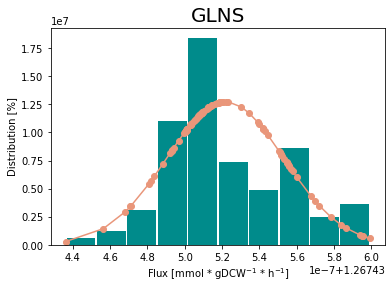

In [96]:
plot_sampled_reaction_fluxes(relaxed_sampled_fluxes, reactions, reaction_id=0)

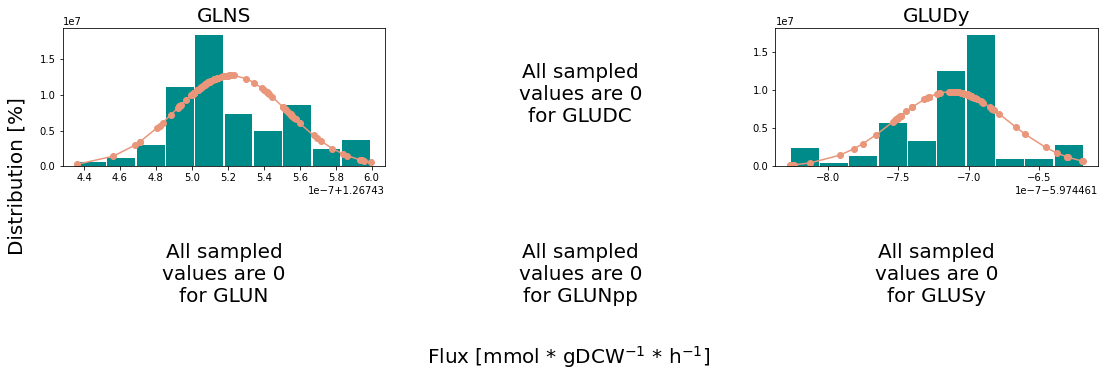

In [97]:
fig = plot_all_subsystem_fluxes(relaxed_sampled_fluxes, reactions, bins=10)

#### Box and whiskers for several reactions of interest to visualize the distribution of points

In [98]:
show_subsystems(model)

0: Extracellular exchange
1: Intracellular demand
2: Biomass and maintenance functions
3: Transport, Inner Membrane
4: Transport, Outer Membrane Porin
5: Transport, Outer Membrane
6: Nucleotide Salvage Pathway
7: Glycerophospholipid Metabolism
8: Alternate Carbon Metabolism
9: Cofactor and Prosthetic Group Biosynthesis
10: Cell Envelope Biosynthesis
11: Methylglyoxal Metabolism
12: Arginine and Proline Metabolism
13: Membrane Lipid Metabolism
14: Pyruvate Metabolism
15: Tyrosine, Tryptophan, and Phenylalanine Metabolism
16: Murein Recycling
17: Valine, Leucine, and Isoleucine Metabolism
18: Nitrogen Metabolism
19: Lipopolysaccharide Biosynthesis / Recycling
20: Unassigned
21: Citric Acid Cycle
22: Inorganic Ion Transport and Metabolism
23: Methionine Metabolism
24: Purine and Pyrimidine Biosynthesis
25: Alanine and Aspartate Metabolism
26: tRNA Charging
27: Cysteine Metabolism
28: Threonine and Lysine Metabolism
29: Histidine Metabolism
30: Oxidative Phosphorylation
31: Glycine and Ser

In [99]:
reduced_relaxed_sampled_fluxes = sampled_fluxes_minrange(relaxed_sampled_fluxes, min_val=-1, max_val=1)

In [100]:
reduced_relaxed_sampled_fluxes

,EX_co2_e,EX_glc__D_e,EX_h_e,EX_h2o_e,EX_ac_e,EX_lac__D_e,EX_nh4_e,EX_o2_e,EX_etoh_e,ABUTt2pp,...,ACONTa_reverse,FUM_reverse,GAPD_reverse,ICDHyr_reverse,PGM_reverse,PTAr_reverse,ACONTb_reverse,PGK_reverse,ACKr_reverse,ACS_reverse
0,13.629215,-10.0,10.867127,28.789590,2.3,2.129663,-7.560577,-8.810505,3.323727,353.898256,...,15.291078,9.795137,4.839931,5.477492,22.280401,6.380482,15.044988,23.256148,12.878630,14.170169
1,13.270592,-10.0,11.225750,28.789615,2.3,2.488336,-7.560577,-8.810505,2.965079,390.111246,...,21.099054,10.382726,6.923479,2.899763,21.849783,4.215512,21.150248,23.196940,14.913710,19.573053
2,12.934926,-10.0,11.561415,28.789519,2.3,2.823810,-7.560577,-8.810505,2.629510,817.308152,...,25.291975,6.621836,3.912877,3.100787,21.782545,6.394704,25.213696,23.187712,21.953873,27.847525
3,13.383559,-10.0,11.112782,28.789671,2.3,2.375481,-7.560577,-8.810505,3.077990,204.214390,...,15.845341,11.722408,7.241533,9.410370,24.005870,12.017718,15.856001,23.493366,18.456227,16.172283
4,13.843082,-10.0,10.653259,28.789605,2.3,1.915825,-7.560577,-8.810505,3.537580,402.779474,...,18.278760,9.311534,6.379143,5.385615,22.021561,4.768060,18.055173,23.220558,13.521122,16.689877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,14.563649,-10.0,9.932693,28.789495,2.3,1.195040,-7.560577,-8.810505,4.258256,53.104954,...,28.674533,27.180510,21.996630,25.593502,29.829680,26.218926,28.641377,24.294088,27.545012,2.531134
96,14.594346,-10.0,9.901995,28.789488,2.3,1.164328,-7.560577,-8.810505,4.288960,58.264457,...,3.233603,1.440165,1.327139,1.003332,21.370090,4.211802,3.089021,23.131008,3.362928,6.333624
97,13.297000,-10.0,11.199342,28.789601,2.3,2.461899,-7.560577,-8.810505,2.991502,515.114762,...,23.948682,11.589477,7.460032,4.657506,23.617200,9.005713,23.774325,23.439940,20.607276,19.542360
98,13.605528,-10.0,10.890814,28.789570,2.3,2.153311,-7.560577,-8.810505,3.300060,347.593932,...,15.584663,8.079300,5.571327,4.593462,21.727702,7.369106,15.355369,23.180162,11.446053,15.509708


[]

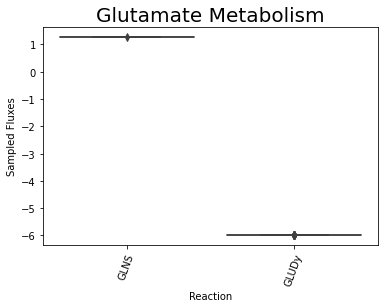

In [102]:
plot_subsystem_fluxes(model, reduced_relaxed_sampled_fluxes, subsystem_id=35, no_zero_cols=True)

#### Calculating the flux splits at key branch points (e.g., glycolysis vs. PPP, TCA vs. acetate secretion, glyoxylate shunt vs. full TCA, etc.)

- Glycolysis/PPP: `EX_glc__D` compared to `PGI` and `G6PDH2r`
- Glyoxylate shunt/full TCA: `ACONTb` compared to `ICDHyr` and `ICL`
- TCA/acetate secretion: (`ACALD`, `PFL`, `PDH`) compared to `PTAr` and `CS`

,Mean,Stdev
EX_glc__D_e/G6PDH2r,0.474612,0.000005
EX_glc__D_e/PGI,0.441922,0.074876


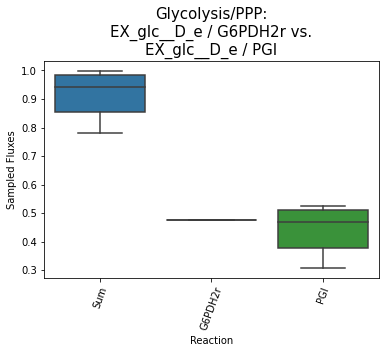

In [103]:
plot_split_ratio(relaxed_sampled_fluxes, 'EX_glc__D_e', 'G6PDH2r', 'PGI', branch_point_name="Glycolysis/PPP")
calculate_split_ratio(relaxed_sampled_fluxes, 'EX_glc__D_e', 'G6PDH2r', 'PGI', branch_point_name="Glycolysis/PPP")

,Mean,Stdev
ACONTb/ICDHyr,5.444998e-01,2.892246e-01
ACONTb/ICL,4.194738e-09,8.836383e-09


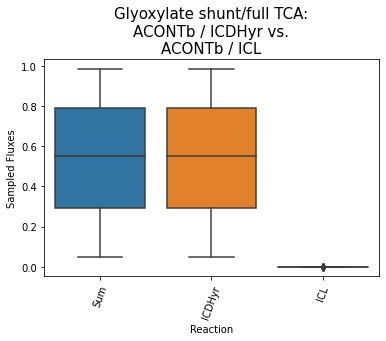

In [104]:
plot_split_ratio(relaxed_sampled_fluxes, 'ACONTb', 'ICDHyr', 'ICL', branch_point_name="Glyoxylate shunt/full TCA")
calculate_split_ratio(relaxed_sampled_fluxes, 'ACONTb', 'ICDHyr', 'ICL', branch_point_name="Glyoxylate shunt/full TCA")

,Mean,Stdev
Glycolysis/PTAr,1.138226,0.955626
Glycolysis/CS,0.119537,0.013380


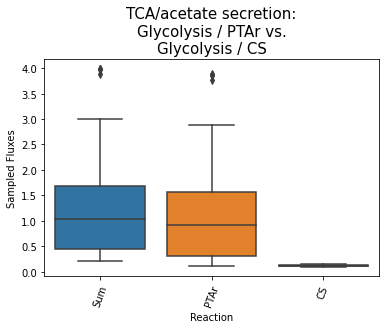

In [105]:
glycolysis = abs(relaxed_sampled_fluxes['ACALD']) + abs(relaxed_sampled_fluxes['PFL']) + abs(relaxed_sampled_fluxes['PDH'])
glycolysis.name = 'Glycolysis'
plot_split_ratio(relaxed_sampled_fluxes, glycolysis, 'PTAr', 'CS', branch_point_name="TCA/acetate secretion")
calculate_split_ratio(relaxed_sampled_fluxes, glycolysis, 'PTAr', 'CS', branch_point_name="TCA/acetate secretion")

#### Calculating the flux resolution

In [106]:
relaxed_sampled_fluxes

,EX_cm_e,EX_cmp_e,EX_co2_e,EX_cobalt2_e,DM_4crsol_c,DM_5drib_c,DM_aacald_c,DM_amob_c,DM_mththf_c,EX_colipa_e,...,ACONTa_reverse,FUM_reverse,GAPD_reverse,ICDHyr_reverse,PGM_reverse,PTAr_reverse,ACONTb_reverse,PGK_reverse,ACKr_reverse,ACS_reverse
0,0.0,0.0,13.629215,-0.000017,0.000156,0.000157,0.0,0.000001,0.000314,1.782228e-12,...,15.291078,9.795137,4.839931,5.477492,22.280401,6.380482,15.044988,23.256148,12.878630,14.170169
1,0.0,0.0,13.270592,-0.000017,0.000156,0.000157,0.0,0.000001,0.000314,5.830472e-13,...,21.099054,10.382726,6.923479,2.899763,21.849783,4.215512,21.150248,23.196940,14.913710,19.573053
2,0.0,0.0,12.934926,-0.000017,0.000156,0.000157,0.0,0.000001,0.000314,4.401567e-13,...,25.291975,6.621836,3.912877,3.100787,21.782545,6.394704,25.213696,23.187712,21.953873,27.847525
3,0.0,0.0,13.383559,-0.000018,0.000156,0.000158,0.0,0.000001,0.000314,-4.111419e-12,...,15.845341,11.722408,7.241533,9.410370,24.005870,12.017718,15.856001,23.493366,18.456227,16.172283
4,0.0,0.0,13.843082,-0.000018,0.000156,0.000158,0.0,0.000001,0.000314,-8.352282e-13,...,18.278760,9.311534,6.379143,5.385615,22.021561,4.768060,18.055173,23.220558,13.521122,16.689877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,14.563649,-0.000018,0.000156,0.000157,0.0,0.000001,0.000314,-6.913157e-14,...,28.674533,27.180510,21.996630,25.593502,29.829680,26.218926,28.641377,24.294088,27.545012,2.531134
96,0.0,0.0,14.594346,-0.000017,0.000156,0.000158,0.0,0.000001,0.000314,5.901516e-13,...,3.233603,1.440165,1.327139,1.003332,21.370090,4.211802,3.089021,23.131008,3.362928,6.333624
97,0.0,0.0,13.297000,-0.000017,0.000156,0.000158,0.0,0.000001,0.000314,9.559723e-12,...,23.948682,11.589477,7.460032,4.657506,23.617200,9.005713,23.774325,23.439940,20.607276,19.542360
98,0.0,0.0,13.605528,-0.000018,0.000156,0.000158,0.0,0.000001,0.000314,-1.209774e-12,...,15.584663,8.079300,5.571327,4.593462,21.727702,7.369106,15.355369,23.180162,11.446053,15.509708


In [107]:
observable_fluxes = get_observable_fluxes(fittedFluxes)

In [108]:
observable_fluxes

,index,simulation_id,simulation_dateAndTime,rxn_id,flux,flux_stdev,flux_lb,flux_ub,flux_units,fit_alf,fit_chi2s,fit_cor,fit_cov,free,used_,comment_
0,0,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,26dap_DASH_MSYN,0.229504,0.002608,0.224392,0.234616,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
4,4,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,ALATA_L,0.343552,0.003904,0.335900,0.351204,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
5,5,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,ArgSYN,0.197824,0.002248,0.193418,0.202230,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
6,6,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,ASNN,0.161216,0.001832,0.157625,0.164807,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
7,7,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,ASPTA,1.279872,0.014544,1.251366,1.327850,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
10,10,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,DAPDC,0.229504,0.002608,0.224392,0.234616,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
11,11,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,BIOMASS_Ec_iJO1366_core_53p95M,0.704000,0.008000,0.688320,0.719680,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
14,14,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,EX_ac_e,2.130000,0.500000,1.917000,2.343000,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
17,17,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,EX_glc_e,7.400000,0.200000,7.007922,7.791993,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None
18,18,WTEColi_113C80_U13C20_01,2021-04-16 18:29:37,EX_nh4_e,4.901952,0.055704,4.792774,5.011130,mmol*gDCW-1*hr-1,0.05,None,None,None,False,True,None


In [109]:
percent_observable_fluxes(fittedFluxes)

27.72 %


In [110]:
get_flux_precision(fittedFluxes)

0.031311574686820484

# Check that in the reimport module

"If the standard deviation of the weighted residuals is significantly different from  one,  then  the  residuals  have  been  improperly weighted resulting in biased flux estimates"

https://reader.elsevier.com/reader/sd/pii/S1096717606000061?token=ABD4DD7567D8BD2D43763248F50716CABA5FEDC3C7E8370AE6F3C514A790D6953F5CCCF7FE22A552BE858AE61F065706&originRegion=eu-west-1&originCreation=20210426154011

In [1]:
%pwd

'/Users/matmat/Documents/GitHub/AutoFlow-OmicsDataHandling/docs/examples'

In [2]:
%cd ../../tests/test_data/MFA_modelInputsData

/Users/matmat/Documents/GitHub/AutoFlow-OmicsDataHandling/tests/test_data/MFA_modelInputsData


In [14]:
# generate test_data
# Last date : 20.04.2021
# By : Matthias Mattanovich (matmat@biosustain.dtu.dk)
# This script is intended to generate sample data and save them into the
# test_data file. The saved objects will then be used to test the
# MFA_sampling functions using unit testing.
import pickle
import pandas as pd
import pathlib
import cobra
from BFAIR.INCA import INCA_reimport
from BFAIR.INCA.sampling import (
    add_constraints,
    find_biomass_reaction,
    get_min_solution_val,
    replace_biomass_rxn_name,
    add_feasible_constraints,
    reshape_fluxes_escher,
    bound_relaxation,
)

current_dir = %pwd #str(pathlib.Path(__file__).parent.absolute())

pd.set_option("mode.chained_assignment", None)
# Use pickle to save python variables
filehandler = open("sampling_test_data.obj", "wb")


def get_bounds_df(model):
    # Helper function to have a way to compare the bounds
    bounds_temp = {}
    for cnt, rxn in enumerate(model.reactions):
        bounds_temp[cnt] = {
            "rxn_id": rxn.id,
            "lb": rxn.lower_bound,
            "ub": rxn.upper_bound,
        }
    return pd.DataFrame.from_dict(bounds_temp, "index")


# Re-import the MFA data
filename = current_dir + "/TestFile.mat"
simulation_info = pd.read_csv(current_dir + "/experimentalMS_data_I.csv")
simulation_id = "WTEColi_113C80_U13C20_01"
reimport_data = INCA_reimport()
(
    fittedData,
    fittedFluxes,
    fittedFragments,
    fittedMeasuredFluxes,
    fittedMeasuredFragments,
    fittedMeasuredFluxResiduals,
    fittedMeasuredFragmentResiduals,
    simulationParameters,
) = reimport_data.reimport(filename, simulation_info, simulation_id)
# Import the conbra model
model = cobra.io.load_json_model(current_dir + "/iJO1366.json")
unconstraint_bounds = get_bounds_df(model)
# Copy the model in order to re-use it a few times
# Get info about the model and the biomass reactions
model_input = model.copy()
constrained_model = add_constraints(model_input, fittedFluxes)
constrained_bounds = get_bounds_df(constrained_model)
find_biomass_reaction(
    constrained_model, biomass_string=["Biomass", "BIOMASS", "biomass"]
)
min_val = get_min_solution_val(fittedFluxes, biomass_string="Biomass")
adj_fittedFluxes = replace_biomass_rxn_name(
    fittedFluxes,
    biomass_rxn_name="BIOMASS_Ec_iJO1366_core_53p95M",
    biomass_string="Biomass",
)
# Only add the constraints that keep the model in the expected range
model_input = model.copy()
feasible_constrained_model, problems = add_feasible_constraints(
    model_input, adj_fittedFluxes, min_val=min_val
)
feasible_constrained_bounds = get_bounds_df(feasible_constrained_model)
# Sample and re-format the output
sampled_fluxes = cobra.sampling.sample(model, n=100, processes=2)
fluxes_sampling = reshape_fluxes_escher(sampled_fluxes)
solution = model.optimize()
fluxes_solution = reshape_fluxes_escher(solution)
# Produce relaxation data
infeasible_model = constrained_model.copy()
cons_table = bound_relaxation(
    infeasible_model,
    adj_fittedFluxes,
    destructive=True,
    fluxes_to_ignore=[],
)
relaxed_bounds = get_bounds_df(infeasible_model)

pickle.dump(
    [
        fittedFluxes,
        unconstraint_bounds,
        constrained_bounds,
        min_val,
        adj_fittedFluxes,
        problems,
        feasible_constrained_bounds,
        sampled_fluxes,
        fluxes_sampling,
        solution,
        fluxes_solution,
        cons_table,
        relaxed_bounds,
    ],
    filehandler,
)

filehandler.close()


Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpk0dwk589.lp
Reading time = 0.03 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmp5qio1n3g.lp
Reading time = 0.03 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
--- start ---
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmp27x1ys4w.lp
Reading time = 0.02 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpyiwhkcwi.lp
Reading time = 0.03 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
add_constraints takes 0h: 0min: 11sec to run
--- end ---
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpfv7aao6w.lp
Reading time = 0.02 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmps2p_kzxx.lp
Reading t

/Users/matmat/opt/anaconda3/envs/bfair/lib/python3.8/site-packages/cobra/util/solver.py:430: UserWarning: solver status is 'infeasible'
  warn("solver status is '{}'".format(status), UserWarning)


Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpzr0kfum2.lp
Reading time = 0.02 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Solution infeasible if adding DAPDC
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpmi95mkyx.lp
Reading time = 0.06 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpxtoqorkb.lp
Reading time = 0.03 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Solution infeasible if adding BIOMASS_Ec_iJO1366_core_53p95M
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmpkrxjlhik.lp
Reading time = 0.03 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /var/folders/mb/7cs2dcbn369_w97fqkfx47brjcxl49/T/tmp_vtlk_5c.lp
Reading time = 0.05 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Solution infeasible if adding GLNS
Read LP format model from file /var/folders